In [ ]:
import os
import warnings
from collections import OrderedDict

import numpy as np
import pandas as pd
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, roc_curve
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

This code essentially organizes and verifies your dataset structure by loading key CSV files and counting files in specific directories, making it easier to reference and use these paths in subsequent processing steps.

**Key Filepath Variables:**

- **trials_dfs['training_set']**: DataFrame for training_set's *trials.csv*  
- **trials_dfs['validation_set']**: DataFrame for validation_set's *trials.csv*  
- **trials_dfs['test_set']**: DataFrame for test_set's *trials.csv*  

- **spk2utt_dfs['training_set']**: DataFrame for training_set's *spk2utt.csv*  
- **spk2utt_dfs['validation_set']**: DataFrame for validation_set's *spk2utt.csv*  
- **spk2utt_dfs['test_set']**: DataFrame for test_set's *spk2utt.csv*  

- **folder_paths[ds][modality]['enroll_path']**: Path to the *speaker_embeddings* folder for a given dataset (ds) and modality (voiceprint or prosody)  
- **folder_paths[ds][modality]['trial_path']**: Path to the *trial_embeddings* folder for a given dataset (ds) and modality (voiceprint or prosody)

In [ ]:
# Dictionary to store loaded feature vectors and labels
dataset_dict = {}

# List of dataset types
dataset_splits = ['training_set', 'validation_set', 'test_set']

# Load features and labels for each dataset split
for split in dataset_splits:
    feature_folder = folder_paths[split]["feature_vector"]
    
    feature_path = os.path.join(feature_folder, 'features.npy')
    label_path = os.path.join(feature_folder, 'labels.npy')
    
    dataset_dict[split] = {
        'features': np.load(feature_path),
        'labels': np.load(label_path)
    }

print("Feature vectors and labels loaded successfully.")

# Assigning loaded data to variables
X_train, y_train = dataset_dict['training_set']['features'], dataset_dict['training_set']['labels']
X_val, y_val = dataset_dict['validation_set']['features'], dataset_dict['validation_set']['labels']
X_test, y_test = dataset_dict['test_set']['features'], dataset_dict['test_set']['labels']

Data loaded successfully.


In [ ]:
def compute_eer(y_true, y_scores):
    """
    Compute the Equal Error Rate (EER) given true labels and predicted scores.
    """
    fpr, tpr = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    # Find threshold where difference between FPR and FNR is minimal.
    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    return eer

## Logistic Regression Model

In [ ]:
# === Step 1: Initial Training on the Training Set ===

print("Training initial Logistic Regression model...")
model_initial = LogisticRegression(solver='saga', max_iter=1000, random_state=42)

%time model_initial.fit(X_train, y_train)
print("Initial training complete.")

Initial training complete.


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# === Step 2: Baseline Testing on the Test Set ===

print("\nEvaluating initial model on test set...")
%time test_probs_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute Equal Error Rate (EER) for baseline model
eer_initial = compute_eer(y_test, test_probs_initial)
print(f"Test EER (Initial Logistic Regression Model): {eer_initial:.4f}")

Test EER (Logistic Regression) with initial model: 0.14864974529456768


In [ ]:
# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the hyperparameter search space
param_search_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'penalty': ['l1', 'l2']
}

# Configure Bayesian search with cross-validation
bayes_search = BayesSearchCV(
    estimator=LogisticRegression(solver='saga', max_iter=1000),
    search_spaces=param_search_space,
    cv=3,  # 3-fold cross-validation
    n_iter=32,  # Number of search iterations
    scoring='roc_auc',  # Optimization metric
    random_state=42,
    n_jobs=-1  # Utilize all available CPU cores
)

print("\nStarting Bayesian hyperparameter search...")
%time bayes_search.fit(X_val, y_val)

# Extract best hyperparameters
best_params = bayes_search.best_params_
print(f"Best parameters found: {best_params}")

CPU times: user 38min 46s, sys: 3min 25s, total: 42min 11s
Wall time: 44.3 s
Best parameters from Bayesian search: OrderedDict([('C', 1.1055125752420899e-06), ('penalty', 'l2')])


In [ ]:
# === Step 4: Retrain Logistic Regression Model with Optimized Parameters ===

print("\nRetraining Logistic Regression model with optimized hyperparameters...")
model_final = LogisticRegression(
    solver='saga', max_iter=1000, **best_params, random_state=42
)

%time model_final.fit(X_train, y_train)
print("Retraining complete.")

Retraining on training set complete.


In [ ]:
# === Step 5: Evaluate the Optimized Model on the Test Set ===

print("\nEvaluating optimized model on test set...")
%time test_probs_final = model_final.predict_proba(X_test)[:, 1]

# Compute EER for optimized model
eer_final = compute_eer(y_test, test_probs_final)
print(f"Test EER (Optimized Logistic Regression Model): {eer_final:.4f}")

Test EER (Logistic Regression) with final model: 0.08688647650208653


## XGBoost

In [ ]:
# === Step 1: Initial Training on the Training Set ===

print("Training XGBoost model...")
model_initial = xgb.XGBClassifier(eval_metric='logloss')

%time model_initial.fit(X_train, y_train)
print("Initial training complete.")

Initial XGBoost training complete.


In [ ]:
# === Step 2: Evaluate Baseline XGBoost Model on Test Set ===

print("\nEvaluating initial XGBoost model on test set...")
%time test_probs_xgb_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute EER for the initial XGBoost model
eer_xgb_initial = compute_eer(y_test, test_probs_xgb_initial)
print(f"Test EER (Initial XGBoost Model): {eer_xgb_initial:.4f}")

Test EER (XGBoost) on initial model: 0.09615198668197494


In [ ]:
# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Configure warnings to ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

xgb_search_space = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

# Configure Bayesian optimization for hyperparameter tuning
xgb_bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=xgb_search_space,
    n_iter=25,  # Number of search iterations
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Utilize all CPU cores
    verbose=2,  # Show search progress
    random_state=42
)

print("\nStarting Bayesian hyperparameter search for XGBoost...")
%time xgb_bayes_search.fit(X_val, y_val)

# Extract the best hyperparameters from Bayesian search
best_xgb_params = xgb_bayes_search.best_params_
print(f"Best parameters found for XGBoost: {best_xgb_params}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
# === Step 4: Retrain XGBoost Model with Optimized Parameters ===

print("\nRetraining XGBoost model with optimized hyperparameters...")
xgb_final_model = XGBClassifier(eval_metric='logloss', **best_xgb_params, random_state=1)

%time xgb_final_model.fit(X_train, y_train)
print("Retraining complete.")

Retraining on training set with best parameters complete.


In [ ]:
# === Step 5: Evaluate the Optimized XGBoost Model on the Test Set ===

print("\nEvaluating optimized XGBoost model on test set...")
%time test_probs_xgb_final = xgb_final_model.predict_proba(X_test)[:, 1]

# Compute EER for the optimized XGBoost model
eer_xgb_final = compute_eer(y_test, test_probs_xgb_final)
print(f"Test EER (Optimized XGBoost Model): {eer_xgb_final:.4f}")

Test EER (XGBoost): 0.04438257451686868


## SVM

In [ ]:
# === Step 1: Initial Training of SVM Model ===

print("\nTraining initial SVM model...")
model_initial = SVC(probability=True, random_state=42)

%time model_initial.fit(X_train, y_train)
print("Initial SVM training complete.")

Initial SVM training complete.


In [ ]:
# === Step 2: Baseline Testing of Initial SVM Model ===

print("\nEvaluating initial SVM model on test set...")
%time test_probs_svm_initial = model_initial.predict_proba(X_test)[:, 1]

# Compute Equal Error Rate (EER) for the initial SVM model
eer_svm_initial = compute_eer(y_test, test_probs_svm_initial)
print(f"Test EER (Initial SVM Model): {eer_svm_initial:.4f}")

Test EER (SVM) on initial model: 0.037340320995741874


In [ ]:
# Source: https://scikit-optimize.github.io/dev/auto_examples/sklearn-gridsearchcv-replacement.html

# 'degree' parameter is excluded here (Source: https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running)

# === Step 3: Bayesian Optimization for Hyperparameter Tuning ===

# Configure warnings to show ConvergenceWarning only once
warnings.filterwarnings("once", category=ConvergenceWarning)

# Define SVM pipeline
svm_pipeline = Pipeline([
    ('model', SVC(cache_size=500000))
])

# Define search space for polynomial and RBF kernels
svm_poly_search_space = {
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1, 8),
    'model__kernel': Categorical(['poly']),
}

svm_rbf_search_space = {
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__kernel': Categorical(['rbf']),
}

# Initialize Bayesian search for hyperparameter tuning
svm_bayes_search = BayesSearchCV(
    estimator=svm_pipeline,
    search_spaces=[(svm_poly_search_space, 10), (svm_rbf_search_space, 10)],  # 10 iterations per search space
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Utilize all available CPU cores
    verbose=2,  # Display search progress
    random_state=42
)

print("\nStarting Bayesian hyperparameter search for SVM...")
%time svm_bayes_search.fit(X_val, y_val)

# Extract best hyperparameters from Bayesian search
best_svm_params = svm_bayes_search.best_params_
print(f"Best parameters found for SVM: {best_svm_params}")

from collections import OrderedDict

best_params = OrderedDict([
    ('model__C', 1e2),
    ('model__gamma', 1.0),
    ('model__degree', 4),
    ('model__kernel', 'poly'),
])


Fitting 3 folds for each of 1 candidates, totalling 3 fits


<Axes: >

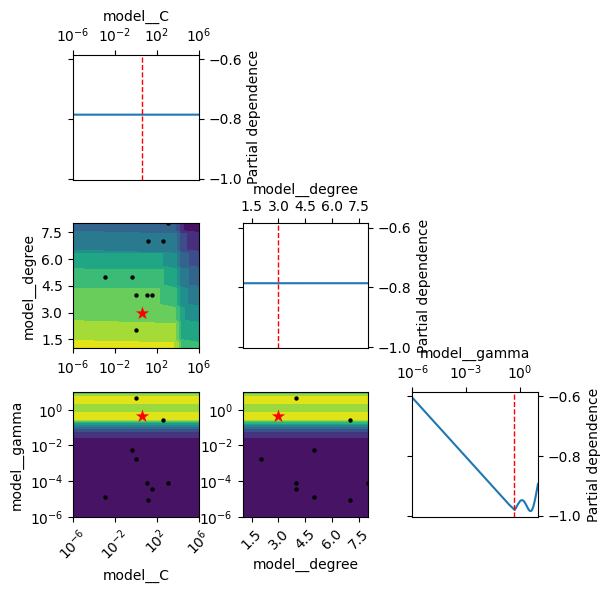

In [ ]:
# Visualize optimization results
plot_objective(svm_bayes_search.optimizer_results_[0])

In [ ]:
# === Step 4: Retrain SVM Model with Optimized Parameters ===

print("\nRetraining SVM model with optimized hyperparameters...")
model_final = SVC(probability=True, **best_svm_params)

%time model_final.fit(X_train, y_train)
print("Retraining complete.")

# unable to run this one, will try again today.

In [ ]:
# === Step 5: Evaluate the Optimized SVM Model on the Test Set ===

print("\nEvaluating optimized SVM model on test set...")
%time test_probs_svm_final = model_final.predict_proba(X_test)[:, 1]

# Compute EER for the optimized SVM model
eer_svm_final = compute_eer(y_test, test_probs_svm_final)
print(f"Test EER (Optimized SVM Model): {eer_svm_final:.4f}")

Test EER (SVM): 0.14864974529456768


## Summary of Results

In [ ]:
# to include ROC curve, fpr n tpr plotting and confusion matrix

# https://www.kaggle.com/code/alimtleuliyev/speaker-verification-evaluation